# Diffusion MRI Data Reconstruction

After pre-processing, the next step is data reconstruction, or model fitting. There are several reconstruction models available within dipy and the full list is available on their website:

https://docs.dipy.org/stable/examples_built/reconstruction/index.html

<br>

In this tutorial we will cover two of the most commonly used Diffusion MRI reconstruction approaches: Diffusion Tensor Imaging (DTI) and Diffusion Kurtosis Imaging (DKI). 

Firstly, we will load general modules and load the pre-processed data:

In [16]:
#load general modules
import os
import numpy as np
import nibabel as nib

#load dipy modules
from dipy.core.gradients import gradient_table
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti, save_nifti

#load modules for visualization
import matplotlib.pyplot as plt

#define the paths to the data
scripts_dir = os.getcwd()
bids_dir = f"{scripts_dir[0:61]}/data/bids"
out_dir = f"{scripts_dir[0:61]}/data/derivatives"

#subject code to be used in this example
sub='01'

#load the pre-processed data
data_preproc, affine = load_nifti(f"{out_dir}/preprocessing/sub-{sub}/eddy_unwarped_images.nii.gz")

#load the bvals and bvecs
bvals, bvecs = read_bvals_bvecs(f"{bids_dir}/sub-{sub}/dwi/sub-{sub}_acq-AP_dwi.bval", f"{out_dir}/preprocessing/sub-{sub}/eddy_unwarped_images.eddy_rotated_bvecs")

#load the binary brain mask
brain_mask, affine_mask = load_nifti(f"{out_dir}/preprocessing/sub-{sub}/hifi_nodif_brain_mask.nii.gz")



## Diffusion Tensor Imaging (DTI)

### DTI Overview:

* Model: DTI is based on a model that assumes water diffusion follows a Gaussian distribution.

* Tensor: It characterizes diffusion using a 3x3 symmetric tensor.

* Parameters: The main parameters derived from DTI are:
    * Fractional Anisotropy (FA): Measures the degree of anisotropy of water diffusion.
    * Mean Diffusivity (MD): Average diffusivity within a voxel.
    * Axial Diffusivity (AD): Diffusivity along the principal axis.
    * Radial Diffusivity (RD): Average diffusivity perpendicular to the principal axis.

* Applications: DTI is widely used to map white matter tracts, study brain connectivity, and investigate diseases affecting white matter integrity.

### Limitations:

* Assumption of Gaussian Diffusion: DTI assumes that water diffusion follows a Gaussian distribution. This assumption is often violated in complex tissues where diffusion is restricted or hindered by cellular structures like membranes and fibers, leading to inaccuracies in regions with complex microstructure.

* Assumption of a single white matter (WM) fibre per voxel: The single-tensor model used in DTI may not accurately represent regions with crossing, kissing, or branching fibres. In such areas, the diffusion process is more complex, and the single-tensor model cannot capture the multiple directions of water diffusion.

* Limited Sensitivity to Microstructural Changes: DTI parameters like FA and MD provide limited information about the underlying tissue microstructure. They may not detect subtle changes or differentiate between different types of tissue alterations (e.g., DTI cannot differentiate neurodegeneration from demyelination).

* Challenges with Interpretation: Interpreting DTI metrics can be challenging, as changes in FA or MD can result from various factors, such as changes in fiber density, myelination, axonal diameter, or the presence of oedema. This makes it difficult to pinpoint the exact cause of observed changes in diffusion metrics. 

### DTI model fitting

The data we are working with comprises of three b-values per dataset: b=0, b=1000 and b=2000 s/mm<sup>2</sup>. The diffusion tensor model is not accurate for b-values greater than approximately 1300 s/mm<sup>2</sup> (see Jones et al, 2004, https://doi.org/10.1002/mrm.20283) and therefore for the next steps we will include only the data acquired with b=0 and 1000 s/mm<sup>2</sup>.  

Text(0.5, 1.0, 'DTI MD map')

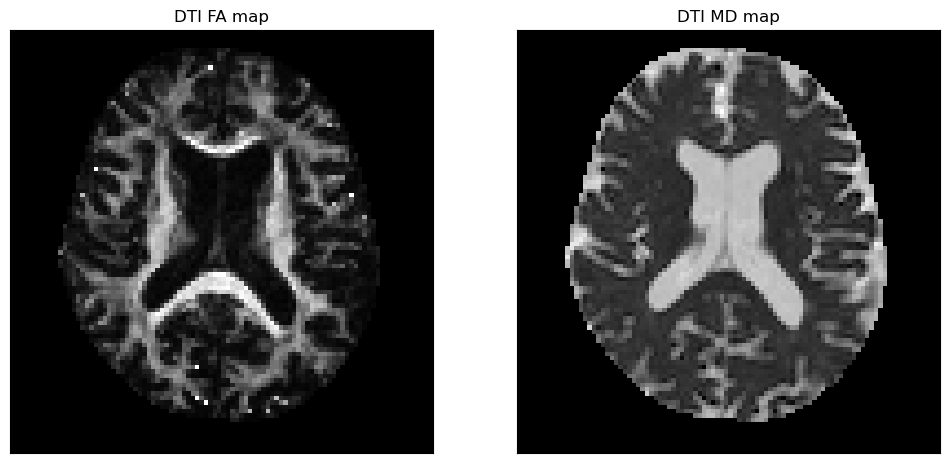

In [17]:
#import the DTI model from dipy
from dipy.reconst.dti import TensorModel

#check if a folder already exists for the output data for this subject, create it if not
dti_path = f"{out_dir}/DTI/sub-{sub}"

if not os.path.exists(dti_path):
    os.makedirs(dti_path)

#select data for DTI model fitting

#create a mask bo b-values less than 1300 s/mm2
bval_mask = bvals < 1300

#select the data for DTI model fitting
data_for_dti = data_preproc[..., bval_mask]

bvals_for_dti = bvals[bval_mask]
bvecs_for_dti = bvecs[bval_mask, :]

#load the gradient table
gtab_for_dti = gradient_table(bvals_for_dti, bvecs_for_dti)

#fit the DTI model
dtimodel = TensorModel(gtab_for_dti)

dtifit = dtimodel.fit(data_for_dti, mask=brain_mask) 

#compute the DTI metrics
fa = dtifit.fa
md= dtifit.md


#save the DTI maps
save_nifti(f"{out_dir}/DTI/sub-{sub}/dti_fa.nii.gz", fa, affine)
save_nifti(f"{out_dir}/DTI/sub-{sub}/dti_md.nii.gz", md, affine)


#plot the middle slice for the FA and MD maps

mid_slice = fa.shape[2] // 2

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

ax.flat[0].imshow(fa[:, :, mid_slice].T, cmap='gray',  interpolation='none' , origin='lower')
ax.flat[0].set_title('DTI FA map')
ax.flat[1].imshow(md[:, :, mid_slice].T, cmap='gray', interpolation='none', origin='lower')
ax.flat[1].set_title('DTI MD map')


In addition to scaler metrics, such as FA and MD, the diffusion tensor also estimates the preferred direction for diffusion within any given voxel (principal diffusion direction). A common way to represent this information is to use colour coded FA maps, where the preferred direction for diffusion is encoded in RGB, and the intensity of each voxel is modulated by the FA value. The colour coding for directionality is as follows:

* Red: Left-Right (medial-lateral)
* Green: Anterior-Posterior (front-back)
* Blue: Superior-Inferior (up-down)  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


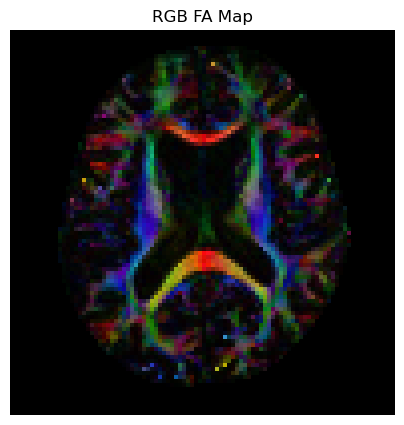

In [18]:
#load the relevant module from dify    
from dipy.reconst.dti import color_fa

#import the rotate function from scipy
from scipy.ndimage import rotate

#make sure the FA is between 0 and 1
fa = np.clip(fa, 0, 1)

#compute the RGB map
RGB_fa = color_fa(fa, dtifit.evecs)

#save the RGB map
save_nifti(f"{out_dir}/DTI/sub-{sub}/dti_tensor_rgb.nii.gz", np.array(255 * RGB_fa, 'uint8'), affine)

# Display the color FA map for the middle slice
plt.figure(figsize=(5, 5))
plt.imshow(rotate(RGB_fa[:,:,mid_slice], -90), origin='lower')
plt.title('RGB FA Map')
plt.axis('off')
plt.show()




We can also visualise the diffusion tensor ellipsoid for each voxel, colour coded as described above. 

In [4]:
from dipy.data import get_sphere
sphere = get_sphere('repulsion724')

from dipy.viz import window, actor

# Enables/disables interactive visualization
interactive = True

scene = window.Scene()

evals = dtifit.evals[13:43, 44:74, 28:29]
evecs = dtifit.evecs[13:43, 44:74, 28:29]

cfa = RGB_fa[13:43, 44:74, 28:29]
cfa /= cfa.max()


scene.add(actor.tensor_slicer(evals, evecs, scalar_colors=cfa, sphere=sphere, scale=0.3))

print('Saving illustration as tensor_ellipsoids.png')
window.record(scene, n_frames=1, out_path=f"{out_dir}/DTI/sub-{sub}/tensor_ellipsoids.png", size=(300, 300))

try:
    # Render and save a single frame
    window.record(scene, n_frames=1, out_path=f"{out_dir}/DTI/sub-{sub}/tensor_ellipsoids.png", size=(300, 300))
except Exception as e:
    print(f"Error occurred: {e}")


if interactive:
    window.show(scene)

## Diffusion Kurtosis Imaging (DKI)

### DKI Overview:

* Model: DKI extends the DTI model by accounting for non-Gaussian diffusion. It includes an additional term that describes the kurtosis of the diffusion signal.

* Tensor: DKI uses both the diffusion tensor and a kurtosis tensor.

* Parameters: In addition to DTI parameters, DKI provides:
    * Mean Kurtosis (MK): A measure of the overall deviation from Gaussian diffusion.
    * Axial Kurtosis (AK): Kurtosis along the principal axis of diffusion.
    * Radial Kurtosis (RK): Kurtosis perpendicular to the principal axis.

* Applications: DKI provides more detailed information about tissue microstructure, useful for studying areas where diffusion is highly restricted or heterogeneous, such as in gray matter or in the presence of pathology like tumors or ischemic lesions.

### Advantages relative to DTI:

* Sensitivity to Microstructural Changes: DKI can detect subtle changes in tissue microstructure that may not be visible with DTI.
 
* Non-Gaussian Diffusion: By modeling non-Gaussian diffusion, DKI provides more accurate information about complex tissues.

### Limitations:

* Increased Complexity and Acquisition Time: DKI requires more diffusion gradient directions and higher b-values, leading to longer scan times and increased sensitivity to motion artifacts.

* Increased Noise in Kurtosis Estimates: The higher b-values required for DKI result in images with lower Signal to Noise Ratio (SNR). This can lead to higher variability and inaccuracies in the estimation of kurtosis metrics. Since DKI involves fitting a more complex model to the diffusion-weighted data, noise can significantly affect the stability and reliability of the kurtosis parameters.

* Artefacts and Outliers: Noise can introduce artifacts and outliers in the diffusion-weighted images, which can propagate through the DKI pipeline, resulting in erroneous kurtosis maps. These artefacts can also obscure true biological variations.

* Higher Computational Demands: The processing and analysis of DKI data are more computationally intensive compared to DTI.

### DKI model fitting

Diffusion data reconstruction using DKI required at least one b-value larger than 2000 s/mm<sup>2</sup>, so for DKI fitting we will use our full dataset. 

100%|██████████| 209221/209221.0 [00:37<00:00, 5566.67it/s]


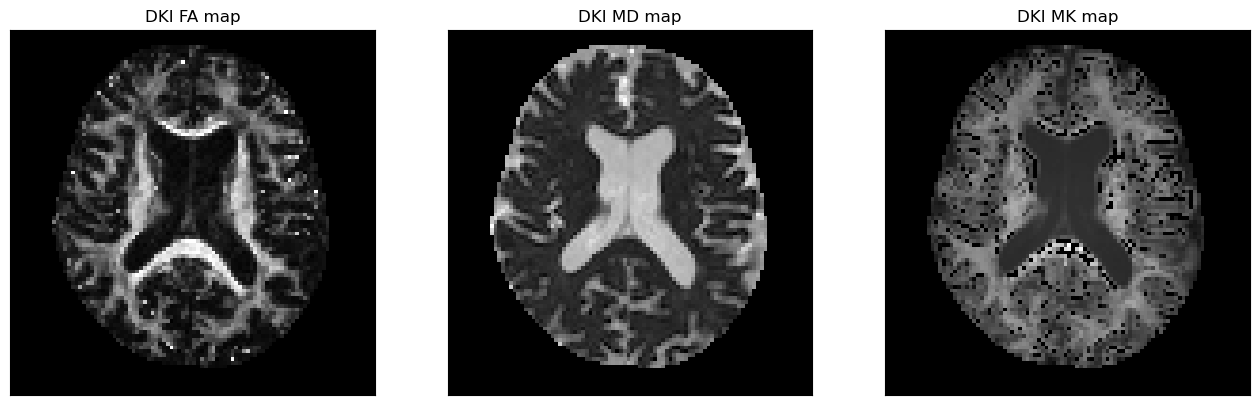

In [20]:
#load DKI model from dipy
import dipy.reconst.dki as dki

#check if a folder already exists for the output data for this subject, create it if not
dki_path = f"{out_dir}/DKI/sub-{sub}"

if not os.path.exists(dki_path):
    os.makedirs(dki_path)

#check whether the MK file exists and if not run DKI model fitting
mk_file_path = f"{out_dir}/DKI/sub-{sub}/dki_mk.nii.gz"

if not os.path.exists(mk_file_path):

    #load the gtab for DKI model fitting
    gtab = gradient_table(bvals, bvecs)

    #fit the DKI model
    dkimodel = dki.DiffusionKurtosisModel(gtab)
    dkifit = dkimodel.fit(data_preproc, mask=brain_mask)

    #compute the DKI metrics
    mk = dkifit.mk(0, 3)
    dki_fa = dkifit.fa
    dki_md = dkifit.md

    #save the DKI maps
    save_nifti(f"{out_dir}/DKI/sub-{sub}/dki_mk.nii.gz", mk, affine)
    save_nifti(f"{out_dir}/DKI/sub-{sub}/dki_fa.nii.gz", dki_fa, affine)
    save_nifti(f"{out_dir}/DKI/sub-{sub}/dki_md.nii.gz", dki_md, affine)


    #plot the middle slice for the MK, FA and MD maps
    fig, ax = plt.subplots(1, 3, figsize=(16, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

    ax.flat[0].imshow(dki_fa[:, :, mid_slice].T, cmap='gray',  interpolation='none' , origin='lower')
    ax.flat[0].set_title('DKI FA map')
    ax.flat[1].imshow(dki_md[:, :, mid_slice].T, cmap='gray', interpolation='none', origin='lower')
    ax.flat[1].set_title('DKI MD map')
    ax.flat[2].imshow(mk[:, :, mid_slice].T, cmap='gray', interpolation='none', vmin=0, vmax=2, origin='lower')
    ax.flat[2].set_title('DKI MK map')

else:
    #load the DKI maps
    mk, _ = load_nifti(f"{out_dir}/DKI/sub-{sub}/dki_mk.nii.gz")
    dki_fa, _  = load_nifti(f"{out_dir}/DKI/sub-{sub}/dki_fa.nii.gz")
    dki_md, _ = load_nifti(f"{out_dir}/DKI/sub-{sub}/dki_md.nii.gz")

    #plot the middle slice for the MK, FA and MD maps
    fig, ax = plt.subplots(1, 3, figsize=(16, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

    ax.flat[0].imshow(dki_fa[:, :, mid_slice].T, cmap='gray',  interpolation='none' , origin='lower')
    ax.flat[0].set_title('DKI FA map')
    ax.flat[1].imshow(dki_md[:, :, mid_slice].T, cmap='gray', interpolation='none', origin='lower')
    ax.flat[1].set_title('DKI MD map')
    ax.flat[2].imshow(mk[:, :, mid_slice].T, cmap='gray', interpolation='none', vmin=0, vmax=2, origin='lower')
    ax.flat[2].set_title('DKI MK map')


### Mean Signal Diffusion Kurtosis Imaging (MSDKI)

The plots above clearly show the impact of low SNR in the metrics obtained with DKI model fitting, for example the dark voxels in the the MK map. A way to overcome this issue is to characterize kurtosis from average signals across all directions acquired for each data b-value (also known as powder-averaged signals). This technique is called Mean Signal Diffusion Kurtosis Imaging (MSDKI). 

Text(0.5, 1.0, 'MSK map')

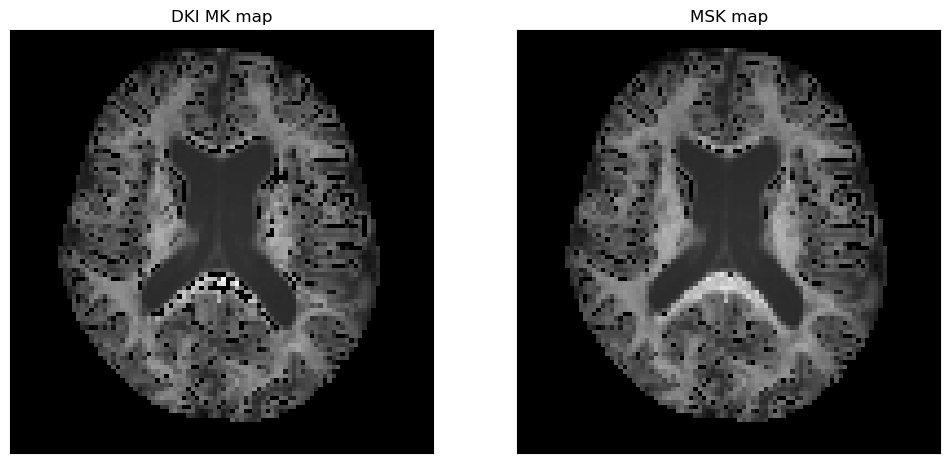

In [24]:
#load the MSK model from dipy
import dipy.reconst.msdki as msdki

msdki_model = msdki.MeanDiffusionKurtosisModel(gtab)
msdki_fit = msdki_model.fit(data_preproc, mask=brain_mask)

#compute the MSDKI metrics
MSD = msdki_fit.msd
MSK = msdki_fit.msk

#save the MSDKI maps
save_nifti(f"{out_dir}/DKI/sub-{sub}/msdki_msd.nii.gz", MSD, affine)
save_nifti(f"{out_dir}/DKI/sub-{sub}/msdki_msk.nii.gz", MSK, affine)

#plot the middle slice for the DKI MK and MSK maps side-by-side

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

ax.flat[0].imshow(mk[:, :, mid_slice].T, cmap='gray',  interpolation='none' , vmin=0, vmax=2, origin='lower')
ax.flat[0].set_title('DKI MK map')
ax.flat[1].imshow(MSK[:, :, mid_slice].T, cmap='gray', interpolation='none', vmin=0, vmax=2, origin='lower')
ax.flat[1].set_title('MSK map')


For MSDKI the full diffusion and kurtosis tensors were not estimated, and therefore only two metrics can be calculated: Mean Signa Diffusion (MSD) and Mean Signal Kurtosis (MSK). While many dark voxels are still present in the MSK map, the number of affected voxels is noticeably reduced when compared to MK obtained from standard DKI fitting. 

# Exercises

Denoising and Gibbs ringing correction are often considered optional pre-processing steps in diffusion MRI, as their relevance depends on the protocol used for data acquisition. For example, denoising becomes more important when working with higher b-values. 

1. Compare the DTI metrics obtained with and without these pre-processing steps. 

2. Evaluate the impact of the same pre-processing methods on the DKI MK metric. 

In [31]:
#Exercise 1

#repeat the eddy command for the raw data

import subprocess

# Define the command to load the FSL module and then execute eddy
def run_eddy(input_file, mask_file, acq_params_file, index_file, bvecs_file, bvals_file, output_base_topup, output_base_eddy):

    #command to run eddy 
    command = (
        f'module load fsl/6.0.5; '
        f'eddy --imain={input_file} '
        f'--mask={mask_file} ' 
        f'--index={index_file} '
        f'--acqp={acq_params_file} '
        f'--bvecs={bvecs_file} '
        f'--bvals={bvals_file} '
        f'--fwhm=0 '
        f'--topup={output_base_topup} '
        f'--flm=quadratic '
        f'--out={output_base_eddy}'
    )

    # Execute the command
    try:
        result = subprocess.run(command, shell=True, check=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print("EDDY completed successfully.")
    except subprocess.CalledProcessError as e:
        print(f"An error occurred: {e}")
        print("Output:\n", e.stdout)
        print("Errors:\n", e.stderr)


# Define paths to the relevant files
input_file_eddy = f"{bids_dir}/sub-{sub}/dwi/sub-{sub}_acq-AP_dwi.nii" #use the denoised data as input
acq_params_file = f"{out_dir}/preprocessing/sub-{sub}/acqparams.txt"
mask_file = f"{out_dir}/preprocessing/sub-{sub}/hifi_nodif_brain_mask.nii.gz"
index_file = f"{out_dir}/preprocessing/sub-{sub}/index.txt"
bvecs_file = f"{bids_dir}/sub-{sub}/dwi/sub-{sub}_acq-AP_dwi.bvec"
bvals_file = f"{bids_dir}/sub-{sub}/dwi/sub-{sub}_acq-AP_dwi.bval"
output_base_topup = f"{out_dir}/preprocessing/sub-{sub}/topup_ap_pa_b0"
output_base_eddy = f"{out_dir}/preprocessing/sub-{sub}/eddy_unwarped_images_raw"


# Run EDDY
run_eddy(input_file_eddy, mask_file, acq_params_file, index_file, bvecs_file, bvals_file, output_base_topup, output_base_eddy)

EDDY completed successfully.


 22%|██▏       | 46780/209221.0 [12:36<43:46, 61.85it/s]  


Text(0.5, 1.0, 'difference MD map')

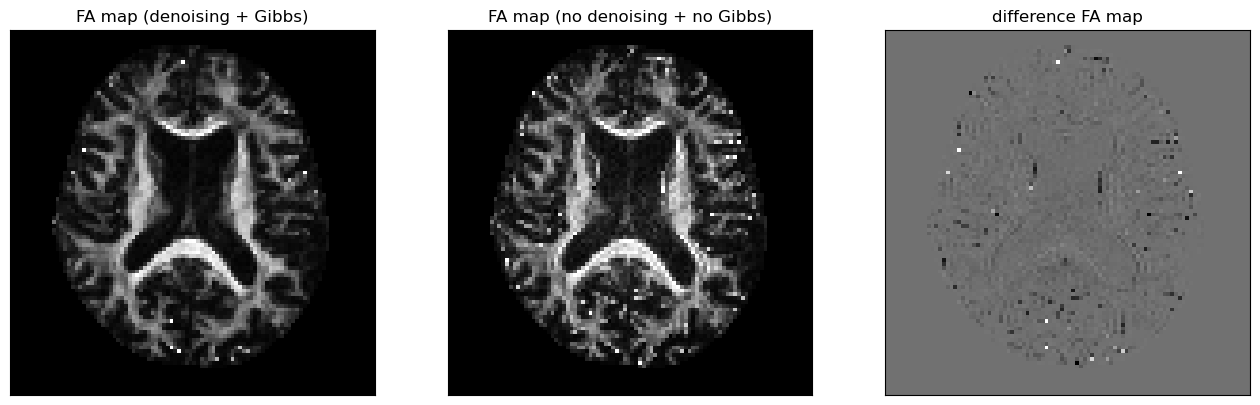

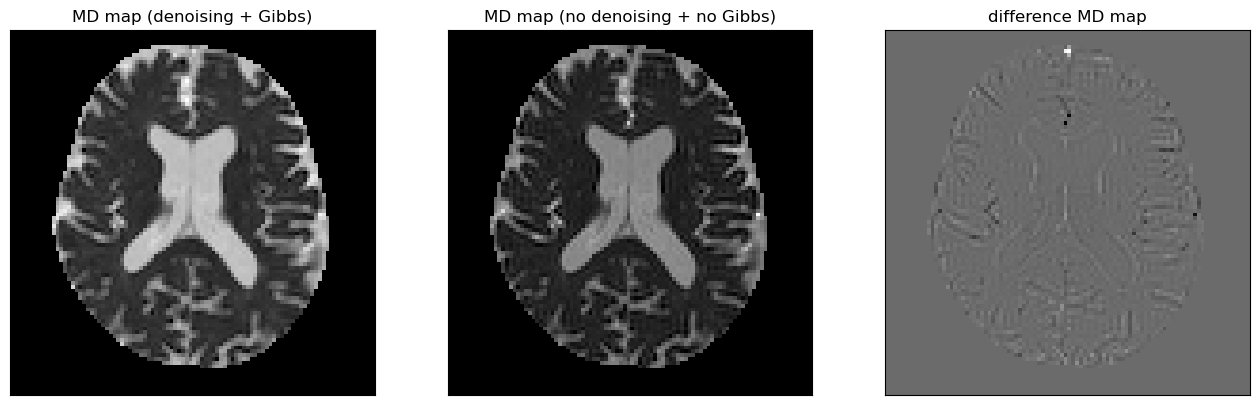

In [52]:
#Fit the DTI model to the data without denoising or Gibbs correction

#load the pre-processed data
data, _ = load_nifti(f"{out_dir}/preprocessing/sub-{sub}/eddy_unwarped_images_raw.nii.gz")

#load the bvals and bvecs
bvals, bvecs = read_bvals_bvecs(f"{bids_dir}/sub-{sub}/dwi/sub-{sub}_acq-AP_dwi.bval", f"{out_dir}/preprocessing/sub-{sub}/eddy_unwarped_images_raw.eddy_rotated_bvecs")

#load the binary brain mask
brain_mask, _ = load_nifti(f"{out_dir}/preprocessing/sub-{sub}/hifi_nodif_brain_mask.nii.gz")

#create a mask bo b-values less than 1300 s/mm2
bval_mask = bvals < 1300

#select the data for DTI model fitting
data_for_dti_raw = data[..., bval_mask]

bvals_for_dti_raw = bvals[bval_mask]
bvecs_for_dti_raw = bvecs[bval_mask, :]

#load the gradient table
gtab_for_dti_raw = gradient_table(bvals_for_dti_raw, bvecs_for_dti_raw)

#fit the DTI model
dtimodel_raw = TensorModel(gtab_for_dti_raw)

dtifit_raw = dtimodel_raw.fit(data_for_dti_raw, mask=brain_mask) 

#compute the DTI metrics
fa_raw = dtifit_raw.fa
md_raw= dtifit_raw.md

#plot the middle slice for the FA maps for comparison
fig, ax = plt.subplots(1, 3, figsize=(16, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

ax.flat[0].imshow(fa[:, :, mid_slice].T, cmap='gray',  interpolation='none' , origin='lower')
ax.flat[0].set_title('FA map (denoising + Gibbs)')
ax.flat[1].imshow(fa_raw[:, :, mid_slice].T, cmap='gray', interpolation='none', origin='lower')
ax.flat[1].set_title('FA map (no denoising + no Gibbs)')
ax.flat[2].imshow((fa[:, :, mid_slice]-fa_raw[:, :, mid_slice]).T, cmap='gray', interpolation='none', origin='lower')
ax.flat[2].set_title('difference FA map')


#plot the middle slice for the FA maps for comparison
fig2, ax2 = plt.subplots(1, 3, figsize=(16, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

ax2.flat[0].imshow(md[:, :, mid_slice].T, cmap='gray',  interpolation='none' , origin='lower')
ax2.flat[0].set_title('MD map (denoising + Gibbs)')
ax2.flat[1].imshow(md_raw[:, :, mid_slice].T, cmap='gray', interpolation='none', origin='lower')
ax2.flat[1].set_title('MD map (no denoising + no Gibbs)')
ax2.flat[2].imshow((md[:, :, mid_slice]-md_raw[:, :, mid_slice]).T, cmap='gray', interpolation='none', origin='lower')
ax2.flat[2].set_title('difference MD map')



Text(0.5, 1.0, 'difference MK map')

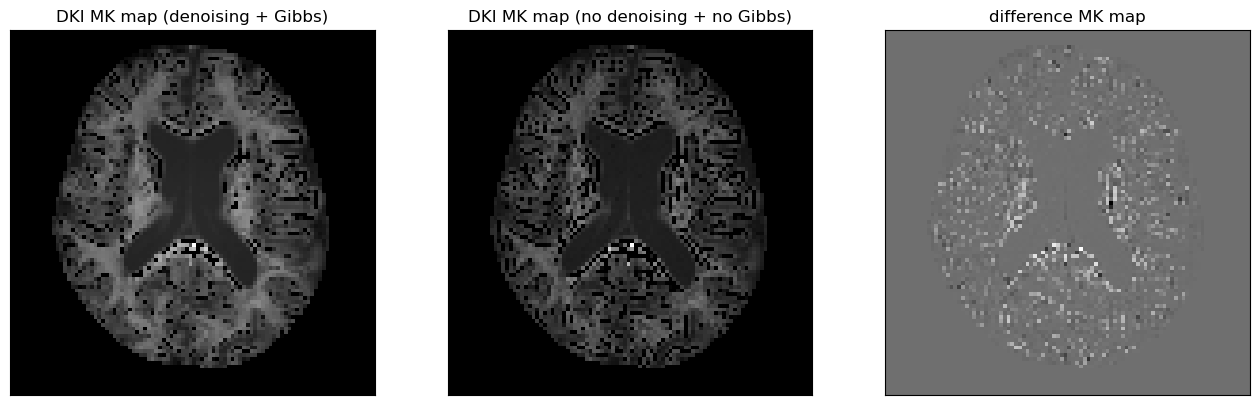

In [53]:
#Exercise 2

#load the gtab for DKI model fitting
gtab = gradient_table(bvals, bvecs)

#fit the DKI model
dkimodel_raw = dki.DiffusionKurtosisModel(gtab)
dkifit_raw = dkimodel_raw.fit(data, mask=brain_mask)

#compute the DKI metrics
mk_raw = dkifit_raw.mk(0, 3)

#plot the middle slice for the MK, FA and MD maps
fig3, ax3 = plt.subplots(1, 3, figsize=(16, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

ax3.flat[0].imshow(mk[:, :, mid_slice].T, cmap='gray',  interpolation='none' , vmin=0, origin='lower')
ax3.flat[0].set_title('DKI MK map (denoising + Gibbs)')
ax3.flat[1].imshow(mk_raw[:, :, mid_slice].T, cmap='gray', interpolation='none', vmin=0, origin='lower')
ax3.flat[1].set_title('DKI MK map (no denoising + no Gibbs)')
ax3.flat[2].imshow((mk[:, :, mid_slice]-mk_raw[:, :, mid_slice]).T, cmap='gray', interpolation='none', origin='lower')
ax3.flat[2].set_title('difference MK map')

